In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
#  ĐỌC DỮ LIỆU GỐC
df = pd.read_csv("nhatot.csv", dtype=str)
print(f"Kích thước dữ liệu gốc: {df.shape}")
print(f"Các cột: {df.columns.tolist()}")

# Hiển thị dữ liệu gốc để kiểm tra
print("\n--- 10 dòng đầu tiên ---")
print(df[["Price", "Area", "Category", "Ward"]].head(10))

Kích thước dữ liệu gốc: (5980, 18)
Các cột: ['ID', 'Title', 'Price', 'Area', 'City', 'District', 'Ward', 'Category', 'Rooms', 'Toilets', 'Latitude', 'Longitude', 'Poster_Type', 'Date_Posted', 'Crawl_Date', 'Legal_Status', 'url', 'source']

--- 10 dòng đầu tiên ---
         Price Area                        Category  \
0   7680000000  111                           Nhà ở   
1      6500000   11                 Căn hộ/Chung cư   
2     12000000  117  Văn phòng, Mặt bằng kinh doanh   
3      6500000  112                 Căn hộ/Chung cư   
4   1400000000   57                             Đất   
5   4850000000  119                 Căn hộ/Chung cư   
6  10500000000  109                           Nhà ở   
7  14000000000   11                             Đất   
8   3200000000  119                           Nhà ở   
9     13000000  102                 Căn hộ/Chung cư   

                                       Ward  
0                                 Phường 11  
1                          Phường Lái

In [3]:
#  LÀM SẠCH DỮ LIỆU CƠ BẢN

# Hàm làm sạch giá
def clean_price(price_str):
    if pd.isna(price_str):
        return None
    price_str = str(price_str).lower().replace(",", ".").strip()
    
    # Loại bỏ giá thỏa thuận
    if "giá thỏa thuận" in price_str or "thương lượng" in price_str or "liên hệ" in price_str:
        return None
    
    # Giá theo đơn vị
    if "tỷ" in price_str:
        nums = re.findall(r"[\d\.]+", price_str)
        if nums:
            return float(nums[0]) * 1000000000  # 1 tỷ = 1 tỷ VND
    elif "triệu" in price_str:
        nums = re.findall(r"[\d\.]+", price_str)
        if nums:
            return float(nums[0]) * 1000000  # 1 triệu = 1,000,000 VND
    elif "ngàn" in price_str or "nghìn" in price_str:
        nums = re.findall(r"[\d\.]+", price_str)
        if nums:
            return float(nums[0]) * 1000  # 1 ngàn = 1,000 VND
    
    # Fallback: tìm số trực tiếp
    nums = re.findall(r"[\d\.]+", price_str)
    if nums:
        num = float(nums[0])
        # KIỂM TRA: Nếu số lớn hơn 1000, coi như đã là số tiền đầy đủ
        if num > 1000:
            return num  # Trả về nguyên giá trị, KHÔNG nhân thêm
        else:
            # Nếu số nhỏ, có thể là đơn vị tỷ
            return num * 1000000000  # tỷ
    
    return None

# Hàm làm sạch diện tích
def clean_area(area_str):
    if pd.isna(area_str):
        return None
    area_str = str(area_str).lower().replace(",", ".")
    
    # Tìm số (có thể có dấu chấm thập phân)
    nums = re.findall(r"[\d\.]+", area_str)
    if nums:
        area = float(nums[0])
        # Nếu diện tích quá lớn (> 1000) có thể là nhầm đơn vị
        if area > 1000:
            return area / 100  # chia để điều chỉnh
        return area
    return None

# %%
# Áp dụng làm sạch
df["Price_clean"] = df["Price"].apply(clean_price)
df["Area_clean"] = df["Area"].apply(clean_area)

# Loại bỏ dòng có giá trị null
initial_count = len(df)
df = df.dropna(subset=["Price_clean", "Area_clean"])
after_clean_count = len(df)

print(f"Đã loại bỏ {initial_count - after_clean_count} dòng có giá/diện tích không hợp lệ")
print(f"Số dòng còn lại: {after_clean_count}")

Đã loại bỏ 0 dòng có giá/diện tích không hợp lệ
Số dòng còn lại: 5980


In [4]:
# Tính giá/m2
df["Price_per_m2"] = df["Price_clean"] / df["Area_clean"]

# Kiểm tra kết quả làm sạch
print("\n--- KẾT QUẢ LÀM SẠCH ---")
sample_data = df[["Price", "Price_clean", "Area", "Area_clean", "Price_per_m2"]].head(10).copy()
sample_data["Price_clean_formatted"] = sample_data["Price_clean"].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else "NaN")
sample_data["Price_per_m2_formatted"] = sample_data["Price_per_m2"].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else "NaN")
print(sample_data[["Price", "Price_clean_formatted", "Area", "Area_clean", "Price_per_m2_formatted"]])


--- KẾT QUẢ LÀM SẠCH ---
         Price Price_clean_formatted Area  Area_clean Price_per_m2_formatted
0   7680000000         7,680,000,000  111       111.0             69,189,189
1      6500000             6,500,000   11        11.0                590,909
2     12000000            12,000,000  117       117.0                102,564
3      6500000             6,500,000  112       112.0                 58,036
4   1400000000         1,400,000,000   57        57.0             24,561,404
5   4850000000         4,850,000,000  119       119.0             40,756,303
6  10500000000        10,500,000,000  109       109.0             96,330,275
7  14000000000        14,000,000,000   11        11.0          1,272,727,273
8   3200000000         3,200,000,000  119       119.0             26,890,756
9     13000000            13,000,000  102       102.0                127,451


In [5]:
#  XỬ LÝ OUTLIERS

def remove_outliers_multiple(df, columns):
    """
    Xử lý outliers cho nhiều cột cùng lúc
    """
    if len(df) == 0:
        return df
        
    mask = pd.Series([True] * len(df))
    
    for col in columns:
        if col not in df.columns:
            print(f" Cảnh báo: Cột '{col}' không tồn tại")
            continue
            
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        # Đảm bảo lower không âm cho các giá trị không thể âm
        if col in ['Price_clean', 'Area_clean', 'Price_per_m2']:
            lower = max(lower, 0)
        
        col_mask = (df[col] >= lower) & (df[col] <= upper)
        mask = mask & col_mask
        
        removed_count = len(df) - col_mask.sum()
        print(f"{col}: Giữ lại {col_mask.sum():,} / {len(df):,} dòng (Loại bỏ {removed_count:,} outliers)")
    
    result_df = df[mask].copy()
    print(f"\nTổng số dòng sau xử lý outliers: {len(result_df):,}")
    return result_df

# Áp dụng xử lý outliers
df_clean = remove_outliers_multiple(df, ['Price_clean', 'Area_clean', 'Price_per_m2'])

Price_clean: Giữ lại 5,592 / 5,980 dòng (Loại bỏ 388 outliers)
Area_clean: Giữ lại 4,999 / 5,980 dòng (Loại bỏ 981 outliers)
Price_per_m2: Giữ lại 5,369 / 5,980 dòng (Loại bỏ 611 outliers)

Tổng số dòng sau xử lý outliers: 4,650


In [6]:
#  XỬ LÝ CÁC BIẾN PHÂN LOẠI

# Tách địa chỉ nếu có cột Location
if 'Location' in df_clean.columns:
    location_split = df_clean['Location'].str.split(',', n=2, expand=True)
    if location_split.shape[1] >= 3:
        df_clean['Street'] = location_split[0].str.strip()
        df_clean['District'] = location_split[1].str.strip()
        df_clean['Province'] = location_split[2].str.strip()
        print("Đã tách cột Location thành Street, District, Province")
    else:
        print(" Cột Location không có đủ thông tin để tách")

# Thống kê biến phân loại
categorical_cols = ['Category', 'Legal_Status']
for col in categorical_cols:
    if col in df_clean.columns:
        print(f"\n--- Phân phối {col} ---")
        print(df_clean[col].value_counts().head(10))


--- Phân phối Category ---
Category
Nhà ở                             2207
Căn hộ/Chung cư                    905
Phòng trọ                          593
Đất                                478
Văn phòng, Mặt bằng kinh doanh     467
Name: count, dtype: int64

--- Phân phối Legal_Status ---
Legal_Status
Sổ hồng riêng    4650
Name: count, dtype: int64


In [7]:
#  TRÍCH XUẤT TỪ KHÓA TỪ TIÊU ĐỀ

if 'Title' in df_clean.columns:
    # Làm sạch title
    df_clean['Title'] = df_clean['Title'].fillna('')
    df_clean['Title_Length'] = df_clean['Title'].str.len()
    
    # Trích xuất từ khóa quan trọng
    important_keywords = ['chính chủ', 'giá rẻ', 'view đẹp', 'mặt tiền', 'sổ đỏ', 'sổ hồng']
    for keyword in important_keywords:
        df_clean[f'Keyword_{keyword.replace(" ", "_")}'] = df_clean['Title'].str.contains(keyword, case=False, na=False).astype(int)
    
    print("Đã trích xuất các từ khóa quan trọng từ tiêu đề")

Đã trích xuất các từ khóa quan trọng từ tiêu đề


In [8]:
#  THỐNG KÊ MÔ TẢ HOÀN CHỈNH

def format_currency(x):
    """Định dạng tiền tệ dễ đọc"""
    if pd.isna(x):
        return "NaN"
    if x >= 1e9:  # Tỷ đồng
        return f"{x/1e9:,.1f} tỷ"
    elif x >= 1e6:  # Triệu đồng
        return f"{x/1e6:,.0f} triệu"
    elif x >= 1e3:  # Ngàn đồng
        return f"{x/1e3:,.0f} nghìn"
    else:
        return f"{x:,.0f} VND"

def format_area(x):
    """Định dạng diện tích"""
    if pd.isna(x):
        return "NaN"
    return f"{x:,.0f} m²"

# Thống kê cho biến định lượng
numeric_cols = ['Price_clean', 'Area_clean', 'Price_per_m2']
print("Thống kê biến định lượng")

for col in numeric_cols:
    if col in df_clean.columns:
        print(f"\n--- {col} ---")
        stats = df_clean[col].describe()
        
        if col == 'Price_clean':
            formatter = format_currency
        elif col == 'Area_clean':
            formatter = format_area
        else:  # Price_per_m2
            formatter = lambda x: f"{format_currency(x)}/m²" if pd.notna(x) else "NaN"
        
        print(f"Số lượng:    {int(stats['count']):,}")
        print(f"Trung bình:  {formatter(stats['mean'])}")
        print(f"Độ lệch chuẩn: {formatter(stats['std'])}")
        print(f"Tối thiểu:   {formatter(stats['min'])}")
        print(f"25%:         {formatter(stats['25%'])}")
        print(f"Trung vị:    {formatter(stats['50%'])}")
        print(f"75%:         {formatter(stats['75%'])}")
        print(f"Tối đa:      {formatter(stats['max'])}")

# Thống kê cho biến phân loại
print("\nThống kê biến phân loại")

categorical_stats = ['Category', 'Legal_Status', 'District', 'Ward']
for col in categorical_stats:
    if col in df_clean.columns:
        print(f"\n--- Phân phối {col} ---")
        value_counts = df_clean[col].value_counts()
        for i, (value, count) in enumerate(value_counts.head(10).items()):
            percentage = (count / len(df_clean)) * 100
            print(f"{i+1:2d}. {value:<30} {count:>5,} dòng ({percentage:.1f}%)")

Thống kê biến định lượng

--- Price_clean ---
Số lượng:    4,650
Trung bình:  2.5 tỷ
Độ lệch chuẩn: 3.3 tỷ
Tối thiểu:   100 nghìn
25%:         9 triệu
Trung vị:    100 triệu
75%:         4.7 tỷ
Tối đa:      13.2 tỷ

--- Area_clean ---
Số lượng:    4,650
Trung bình:  104 m²
Độ lệch chuẩn: 18 m²
Tối thiểu:   31 m²
25%:         102 m²
Trung vị:    109 m²
75%:         113 m²
Tối đa:      130 m²

--- Price_per_m2 ---
Số lượng:    4,650
Trung bình:  25 triệu/m²
Độ lệch chuẩn: 33 triệu/m²
Tối thiểu:   926 VND/m²
25%:         83 nghìn/m²
Trung vị:    1 triệu/m²
75%:         46 triệu/m²
Tối đa:      173 triệu/m²

Thống kê biến phân loại

--- Phân phối Category ---
 1. Nhà ở                          2,207 dòng (47.5%)
 2. Căn hộ/Chung cư                  905 dòng (19.5%)
 3. Phòng trọ                        593 dòng (12.8%)
 4. Đất                              478 dòng (10.3%)
 5. Văn phòng, Mặt bằng kinh doanh   467 dòng (10.0%)

--- Phân phối Legal_Status ---
 1. Sổ hồng riêng                 

In [9]:
#  PHÂN TÍCH MỐI QUAN HỆ CƠ BẢN

# Mối quan hệ giữa diện tích và giá
if all(col in df_clean.columns for col in ['Area_clean', 'Price_clean']):
    correlation = df_clean['Area_clean'].corr(df_clean['Price_clean'])
    print(f" Tương quan giữa Diện tích và Giá: {correlation:.3f}")
    
    if abs(correlation) > 0.5:
        print("   → Mối quan hệ mạnh")
    elif abs(correlation) > 0.3:
        print("   → Mối quan hệ trung bình")
    else:
        print("   → Mối quan hệ yếu")

# Giá trung bình theo loại hình BĐS
if 'Category' in df_clean.columns:
    print(f"\n Giá trung bình theo loại hình bất động sản")
    price_by_type = df_clean.groupby('Category')['Price_clean'].agg(['count', 'mean', 'median']).round(0)
    price_by_type = price_by_type.sort_values('count', ascending=False)
    
    for prop_type, row in price_by_type.head().iterrows():
        mean_price = format_currency(row['mean'])
        median_price = format_currency(row['median'])
        print(f"   {prop_type:<20}: {row['count']:>3} BĐS | TB: {mean_price:>15} | Trung vị: {median_price:>15}")

 Tương quan giữa Diện tích và Giá: -0.002
   → Mối quan hệ yếu

 Giá trung bình theo loại hình bất động sản
   Nhà ở               : 2207.0 BĐS | TB:          3.9 tỷ | Trung vị:          3.8 tỷ
   Căn hộ/Chung cư     : 905.0 BĐS | TB:          1.1 tỷ | Trung vị:        11 triệu
   Phòng trọ           : 593.0 BĐS | TB:         4 triệu | Trung vị:         3 triệu
   Đất                 : 478.0 BĐS | TB:          4.0 tỷ | Trung vị:          3.7 tỷ
   Văn phòng, Mặt bằng kinh doanh: 467.0 BĐS | TB:        76 triệu | Trung vị:        30 triệu


In [10]:
#  XUẤT KẾT QUẢ

# Lưu file đã làm sạch
output_file = "Nhatot_cleaned.csv"
df_clean.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"Đã lưu file đã làm sạch: {output_file}")

# Tóm tắt kết quả
print(f"\nTóm tắt kết quả")
print(f"• Số lượng BĐS ban đầu: {len(df):,}")
print(f"• Số lượng BĐS sau làm sạch: {len(df_clean):,}")
print(f"• Tỷ lệ giữ lại: {len(df_clean)/len(df)*100:.1f}%")

if len(df_clean) > 0:
    avg_price = format_currency(df_clean['Price_clean'].mean())
    avg_area = format_area(df_clean['Area_clean'].mean())
    avg_price_m2 = format_currency(df_clean['Price_per_m2'].mean()) + "/m²"
    
    print(f"• Giá trung bình: {avg_price}")
    print(f"• Diện tích trung bình: {avg_area}")
    print(f"• Giá/m² trung bình: {avg_price_m2}")

print(f"\nHoàn tất xử lý dữ liệu")

# Hiển thị một số dòng kết quả cuối cùng
print("\n=== Dữ liệu sau khi xử lý ===")
final_cols = [col for col in ['Price_clean', 'Area_clean', 'Price_per_m2', 'Category', 'District', 'Ward'] if col in df_clean.columns]
print(df_clean[final_cols].head(10))

Đã lưu file đã làm sạch: Nhatot_cleaned.csv

Tóm tắt kết quả
• Số lượng BĐS ban đầu: 5,980
• Số lượng BĐS sau làm sạch: 4,650
• Tỷ lệ giữ lại: 77.8%
• Giá trung bình: 2.5 tỷ
• Diện tích trung bình: 104 m²
• Giá/m² trung bình: 25 triệu/m²

Hoàn tất xử lý dữ liệu

=== Dữ liệu sau khi xử lý ===
     Price_clean  Area_clean  Price_per_m2                        Category  \
0   7.680000e+09       111.0  6.918919e+07                           Nhà ở   
2   1.200000e+07       117.0  1.025641e+05  Văn phòng, Mặt bằng kinh doanh   
3   6.500000e+06       112.0  5.803571e+04                 Căn hộ/Chung cư   
4   1.400000e+09        57.0  2.456140e+07                             Đất   
5   4.850000e+09       119.0  4.075630e+07                 Căn hộ/Chung cư   
6   1.050000e+10       109.0  9.633028e+07                           Nhà ở   
8   3.200000e+09       119.0  2.689076e+07                           Nhà ở   
9   1.300000e+07       102.0  1.274510e+05                 Căn hộ/Chung cư   
12  4

In [11]:
# Set style cho đồ thị
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [12]:
# Load dữ liệu đã làm sạch
try:
    df = pd.read_csv("Nhatot_cleaned.csv")
    print(f" Kích thước dữ liệu EDA: {df.shape}")
except:
    print(" Không tìm thấy file Nhatot_cleaned.csv")
    print(" Hãy chạy lại code xử lý dữ liệu trước khi chạy EDA")
    df = pd.DataFrame()

if len(df) == 0:
    print(" Không có dữ liệu để phân tích")
else:
    print(" Dữ liệu đã được load thành công")

 Kích thước dữ liệu EDA: (4650, 28)
 Dữ liệu đã được load thành công


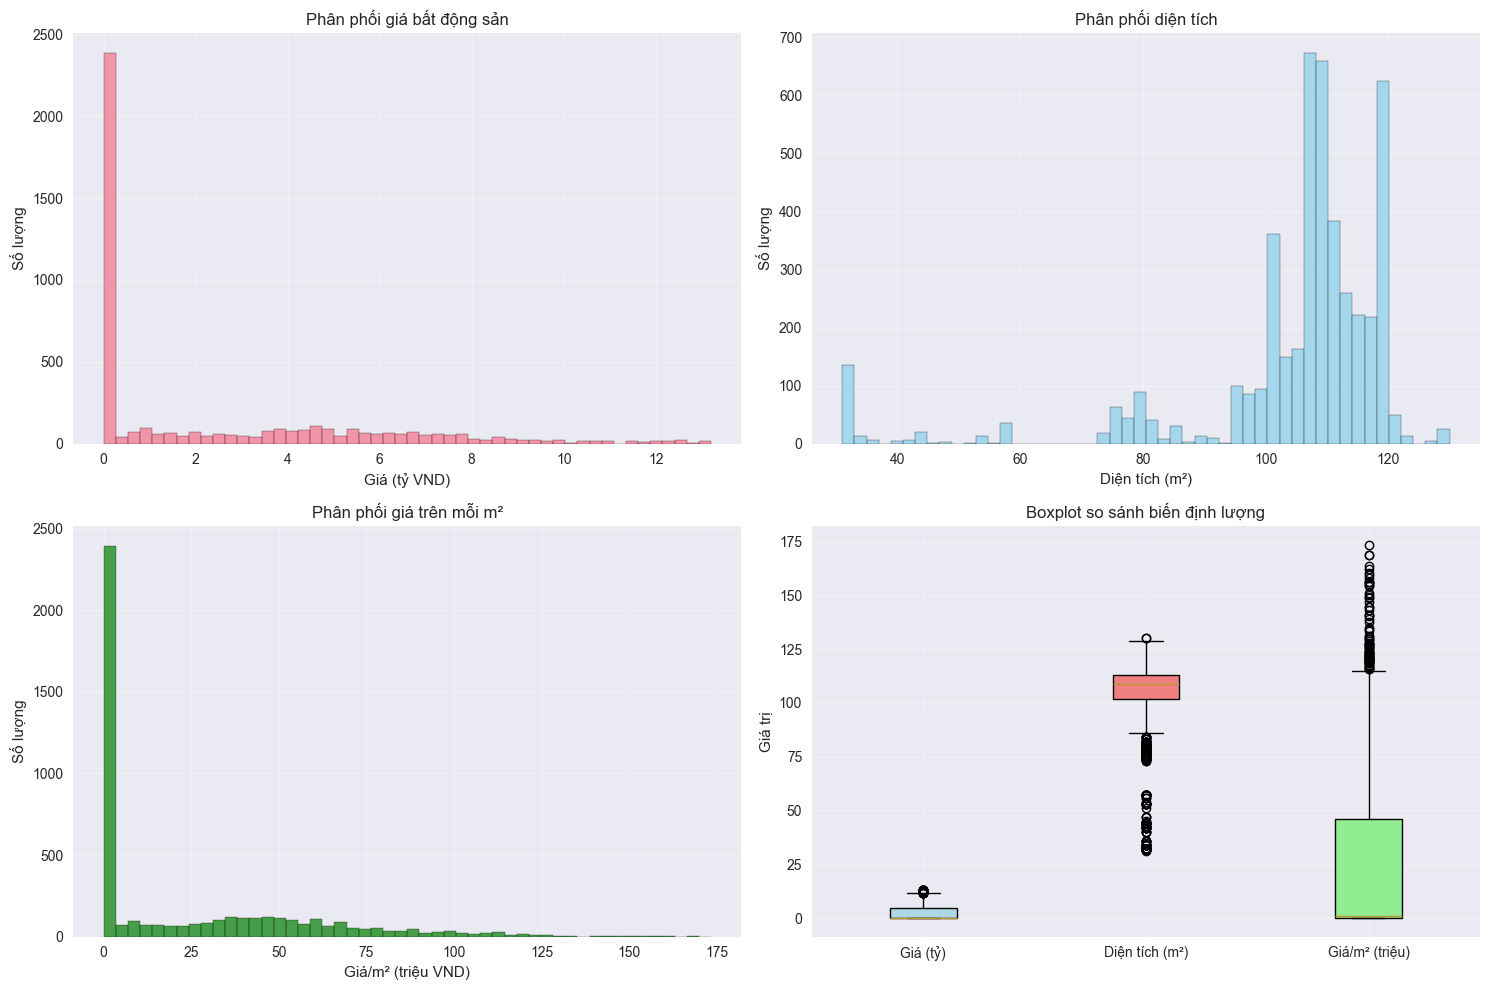

In [13]:
##  PHÂN TÍCH PHÂN PHỐI CÁC BIẾN CHÍNH

# %%
if len(df) > 0:
    # 1.1 Phân phối giá bất động sản
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Phân phối giá (chuyển đổi đơn vị trước khi vẽ)
    price_billion = df['Price_clean'] / 1e9
    axes[0,0].hist(price_billion, bins=50, alpha=0.7, edgecolor='black')
    axes[0,0].set_xlabel('Giá (tỷ VND)')
    axes[0,0].set_ylabel('Số lượng')
    axes[0,0].set_title('Phân phối giá bất động sản')
    axes[0,0].grid(True, alpha=0.3)

    # Phân phối diện tích
    axes[0,1].hist(df['Area_clean'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    axes[0,1].set_xlabel('Diện tích (m²)')
    axes[0,1].set_ylabel('Số lượng')
    axes[0,1].set_title('Phân phối diện tích')
    axes[0,1].grid(True, alpha=0.3)

    # Phân phối giá/m² (chuyển đổi đơn vị)
    price_m2_million = df['Price_per_m2'] / 1e6
    axes[1,0].hist(price_m2_million, bins=50, alpha=0.7, edgecolor='black', color='green')
    axes[1,0].set_xlabel('Giá/m² (triệu VND)')
    axes[1,0].set_ylabel('Số lượng')
    axes[1,0].set_title('Phân phối giá trên mỗi m²')
    axes[1,0].grid(True, alpha=0.3)

    # Boxplot so sánh (dữ liệu đã chuyển đổi)
    plot_data = [price_billion, df['Area_clean'], price_m2_million]
    labels = ['Giá (tỷ)', 'Diện tích (m²)', 'Giá/m² (triệu)']
    box_plot = axes[1,1].boxplot(plot_data, labels=labels, patch_artist=True)
    
    # Tô màu cho boxplot
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[1,1].set_ylabel('Giá trị')
    axes[1,1].set_title('Boxplot so sánh biến định lượng')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [14]:
# %%
if len(df) > 0:
    # Thống kê mô tả chi tiết
    print(" THỐNG KÊ MÔ TẢ CHI TIẾT")

    def detailed_stats(series, name):
        print(f"\n--- {name} ---")
        print(f"Mean: {series.mean():,.0f}")
        print(f"Median: {series.median():,.0f}")
        print(f"Std: {series.std():,.0f}")
        print(f"Min: {series.min():,.0f}")
        print(f"Max: {series.max():,.0f}")
        print(f"Skewness: {series.skew():.3f} ({'Lệch phải' if series.skew() > 0 else 'Lệch trái' if series.skew() < 0 else 'Đối xứng'})")
        print(f"Kurtosis: {series.kurtosis():.3f}")

    detailed_stats(df['Price_clean'], "Giá bất động sản (VND)")
    detailed_stats(df['Area_clean'], "Diện tích (m²)")
    detailed_stats(df['Price_per_m2'], "Giá trên m² (VND/m²)")

 THỐNG KÊ MÔ TẢ CHI TIẾT

--- Giá bất động sản (VND) ---
Mean: 2,465,795,376
Median: 100,000,000
Std: 3,266,693,959
Min: 100,000
Max: 13,200,000,000
Skewness: 1.190 (Lệch phải)
Kurtosis: 0.467

--- Diện tích (m²) ---
Mean: 104
Median: 109
Std: 18
Min: 31
Max: 130
Skewness: -2.546 (Lệch trái)
Kurtosis: 6.748

--- Giá trên m² (VND/m²) ---
Mean: 25,067,465
Median: 1,024,223
Std: 33,305,447
Min: 926
Max: 173,333,333
Skewness: 1.295 (Lệch phải)
Kurtosis: 1.071


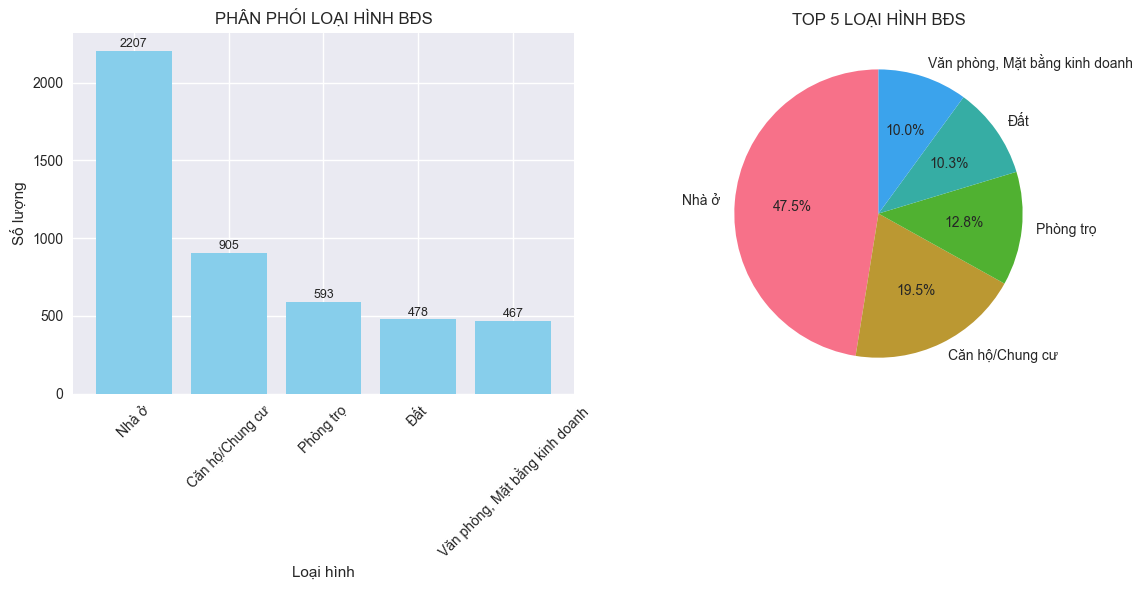

 GIÁ TRUNG BÌNH THEO LOẠI HÌNH BĐS
                                Count    Price_Mean  Price_Median  Area_Mean  \
Category                                                                       
Nhà ở                            2207  3.863093e+09  3.800000e+09      105.0   
Căn hộ/Chung cư                   905  1.105490e+09  1.100000e+07      106.0   
Phòng trọ                         593  3.501003e+06  3.400000e+06      107.0   
Đất                               478  3.979663e+09  3.700000e+09       93.0   
Văn phòng, Mặt bằng kinh doanh    467  7.554481e+07  3.000000e+07      106.0   

                                Price_m2_Mean  
Category                                       
Nhà ở                              38469357.0  
Căn hộ/Chung cư                    11190924.0  
Phòng trọ                             32933.0  
Đất                                44316686.0  
Văn phòng, Mặt bằng kinh doanh       709099.0  


In [15]:
##  PHÂN TÍCH THEO LOẠI HÌNH BẤT ĐỘNG SẢN

# %%
if len(df) > 0 and 'Category' in df.columns:
    # 2.1 Phân phối loại hình BĐS
    plt.figure(figsize=(12, 6))
    prop_type_counts = df['Category'].value_counts()
    
    # Biểu đồ cột
    plt.subplot(1, 2, 1)
    bars = plt.bar(range(len(prop_type_counts.head(10))), prop_type_counts.head(10).values, color='skyblue')
    plt.title('PHÂN PHỐI LOẠI HÌNH BĐS')
    plt.xlabel('Loại hình')
    plt.ylabel('Số lượng')
    plt.xticks(range(len(prop_type_counts.head(10))), prop_type_counts.head(10).index, rotation=45)
    
    # Thêm số liệu trên đầu cột
    for bar, count in zip(bars, prop_type_counts.head(10).values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{count}', 
                ha='center', va='bottom', fontsize=9)
    
    # Biểu đồ tròn
    plt.subplot(1, 2, 2)
    top_5 = prop_type_counts.head(5)
    plt.pie(top_5.values, labels=top_5.index, autopct='%1.1f%%', startangle=90)
    plt.title('TOP 5 LOẠI HÌNH BĐS')
    
    plt.tight_layout()
    plt.show()

    # 2.2 Giá trung bình theo loại hình
    price_by_type = df.groupby('Category').agg({
        'Price_clean': ['count', 'mean', 'median'],
        'Area_clean': 'mean',
        'Price_per_m2': 'mean'
    }).round(0)
    
    price_by_type.columns = ['Count', 'Price_Mean', 'Price_Median', 'Area_Mean', 'Price_m2_Mean']
    price_by_type = price_by_type.sort_values('Count', ascending=False)
    
    print(" GIÁ TRUNG BÌNH THEO LOẠI HÌNH BĐS")
    print(price_by_type.head(10))

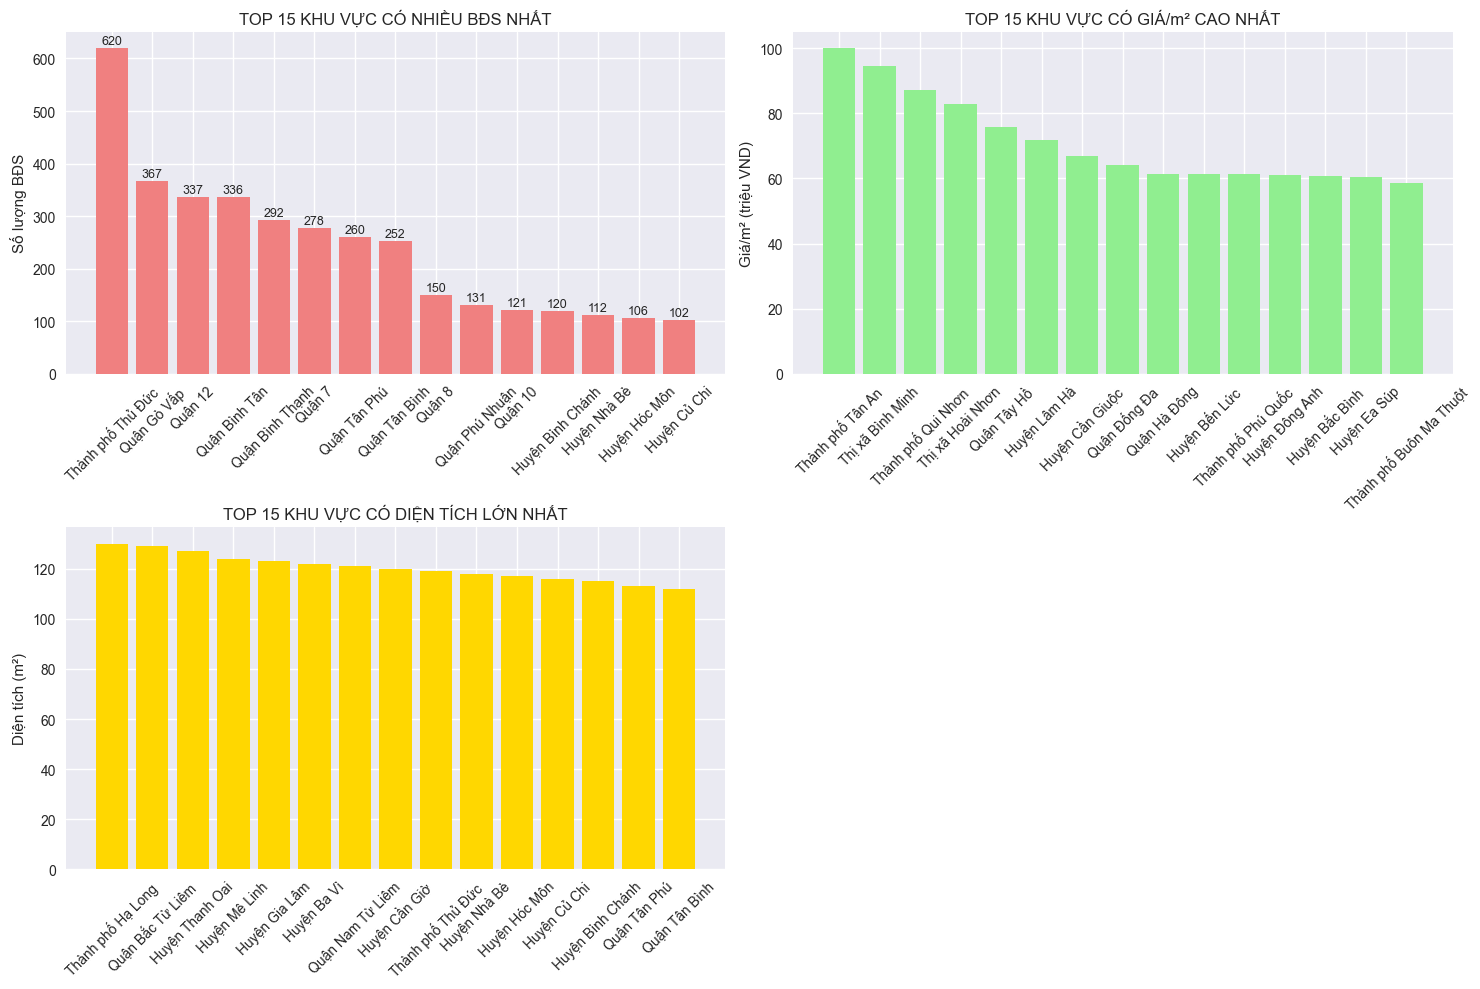

In [16]:
##  PHÂN TÍCH THEO VỊ TRÍ ĐỊA LÝ

# %%
if len(df) > 0 and 'District' in df.columns:
    # 3.1 Phân tích theo KHU VỰC
    plt.figure(figsize=(15, 10))
    
    # Top quận có nhiều BĐS nhất
    district_counts = df['District'].value_counts().head(15)
    
    plt.subplot(2, 2, 1)
    bars1 = plt.bar(range(len(district_counts)), district_counts.values, color='lightcoral')
    plt.title('TOP 15 KHU VỰC CÓ NHIỀU BĐS NHẤT')
    plt.xticks(range(len(district_counts)), district_counts.index, rotation=45)
    plt.ylabel('Số lượng BĐS')
    
    # Thêm số liệu trên cột
    for bar, count in zip(bars1, district_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{count}', 
                ha='center', va='bottom', fontsize=9)
    
    # Giá trung bình theo quận
    plt.subplot(2, 2, 2)
    district_price = df.groupby('District')['Price_per_m2'].mean().sort_values(ascending=False).head(15)
    bars2 = plt.bar(range(len(district_price)), district_price.values / 1e6, color='lightgreen')
    plt.title('TOP 15 KHU VỰC CÓ GIÁ/m² CAO NHẤT')
    plt.xticks(range(len(district_price)), district_price.index, rotation=45)
    plt.ylabel('Giá/m² (triệu VND)')
    
    # Diện tích trung bình theo quận
    plt.subplot(2, 2, 3)
    district_area = df.groupby('District')['Area_clean'].mean().sort_values(ascending=False).head(15)
    bars3 = plt.bar(range(len(district_area)), district_area.values, color='gold')
    plt.title('TOP 15 KHU VỰC CÓ DIỆN TÍCH LỚN NHẤT')
    plt.xticks(range(len(district_area)), district_area.index, rotation=45)
    plt.ylabel('Diện tích (m²)')
    
    
    plt.tight_layout()
    plt.show()

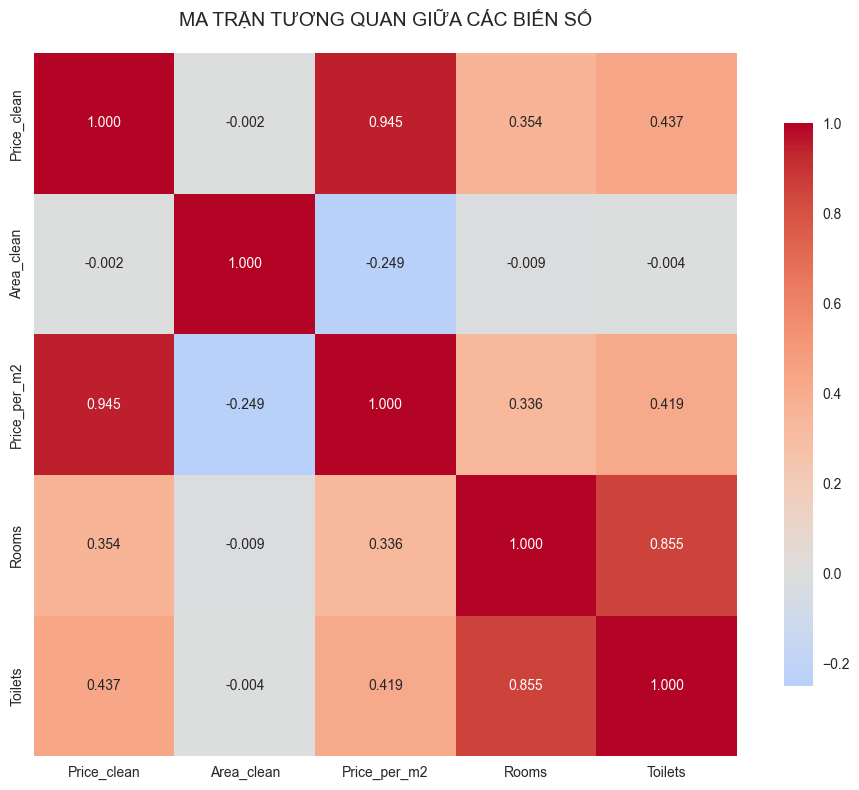

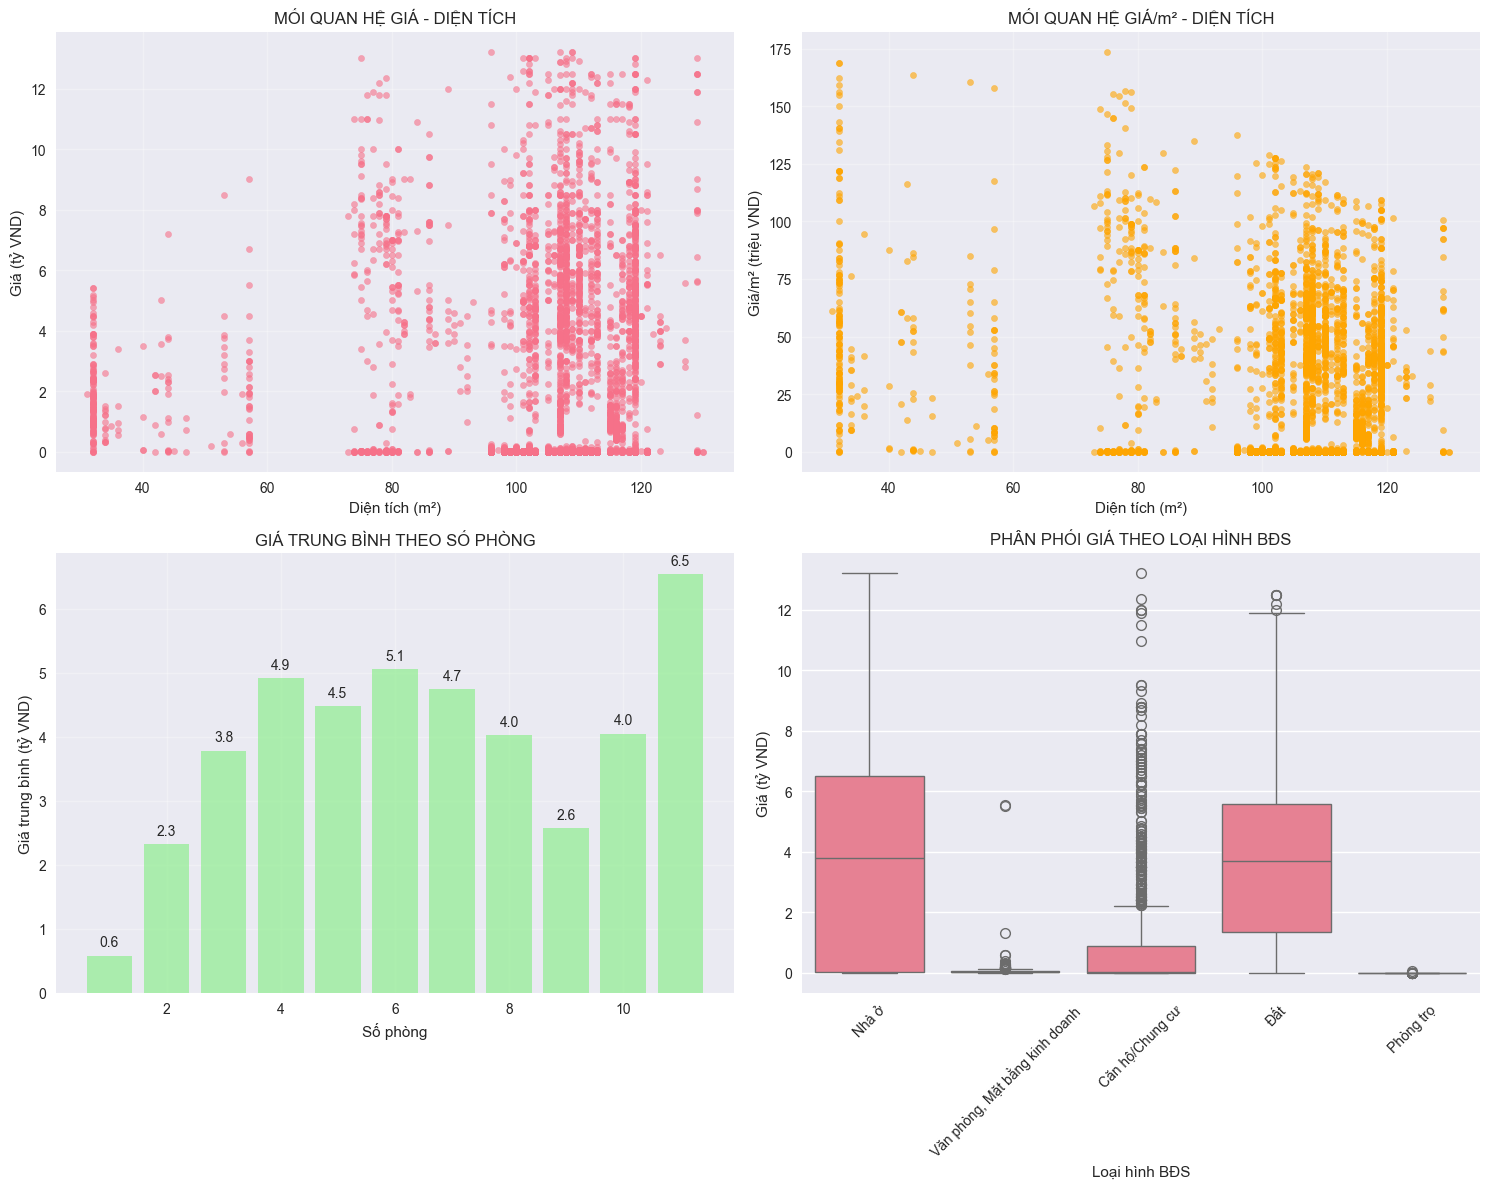

In [17]:
##  PHÂN TÍCH MỐI QUAN HỆ GIỮA CÁC BIẾN

# %%
if len(df) > 0:
    # 4.1 Ma trận tương quan
    numeric_cols = ['Price_clean', 'Area_clean', 'Price_per_m2']
    if 'Rooms' in df.columns:
        numeric_cols.append('Rooms')
    if 'Toilets' in df.columns:
        numeric_cols.append('Toilets')

    # Chỉ lấy các cột tồn tại
    numeric_cols = [col for col in numeric_cols if col in df.columns]
    
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[numeric_cols].corr()

        # Heatmap tương quan
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                    square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
        plt.title('MA TRẬN TƯƠNG QUAN GIỮA CÁC BIẾN SỐ', fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        # 4.2 Phân tích chi tiết từng mối quan hệ
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Giá vs Diện tích
        axes[0,0].scatter(df['Area_clean'], df['Price_clean']/1e9, alpha=0.6, s=20)
        axes[0,0].set_xlabel('Diện tích (m²)')
        axes[0,0].set_ylabel('Giá (tỷ VND)')
        axes[0,0].set_title('MỐI QUAN HỆ GIÁ - DIỆN TÍCH')
        axes[0,0].grid(True, alpha=0.3)

        # Giá/m² vs Diện tích
        axes[0,1].scatter(df['Area_clean'], df['Price_per_m2']/1e6, alpha=0.6, s=20, color='orange')
        axes[0,1].set_xlabel('Diện tích (m²)')
        axes[0,1].set_ylabel('Giá/m² (triệu VND)')
        axes[0,1].set_title('MỐI QUAN HỆ GIÁ/m² - DIỆN TÍCH')
        axes[0,1].grid(True, alpha=0.3)

        # Giá vs Số phòng (Rooms) nếu có
        if 'Rooms' in df.columns:
            room_price = df.groupby('Rooms')['Price_clean'].mean() / 1e9
            axes[1,0].bar(room_price.index, room_price.values, color='lightgreen', alpha=0.7)
            axes[1,0].set_xlabel('Số phòng')
            axes[1,0].set_ylabel('Giá trung bình (tỷ VND)')
            axes[1,0].set_title('GIÁ TRUNG BÌNH THEO SỐ PHÒNG')
            axes[1,0].grid(True, alpha=0.3)
            
            for i, v in enumerate(room_price.values):
                axes[1,0].text(room_price.index[i], v + 0.1, f'{v:.1f}', ha='center', va='bottom')

        # Phân phối giá theo Category (thay cho Property Type)
        if 'Category' in df.columns:
            plot_data = df.copy()
            plot_data['Price_billion'] = plot_data['Price_clean'] / 1e9
            
            top_categories = df['Category'].value_counts().head(5).index
            cat_data = plot_data[plot_data['Category'].isin(top_categories)]
            
            sns.boxplot(data=cat_data, x='Category', y='Price_billion', ax=axes[1,1])
            axes[1,1].set_xlabel('Loại hình BĐS')
            axes[1,1].set_ylabel('Giá (tỷ VND)')
            axes[1,1].set_title('PHÂN PHỐI GIÁ THEO LOẠI HÌNH BĐS')
            axes[1,1].tick_params(axis='x', rotation=45)

        # Ẩn subplot không sử dụng
        for i in range(2):
            for j in range(2):
                if not axes[i,j].has_data():
                    axes[i,j].set_visible(False)

        plt.tight_layout()
        plt.show()

In [18]:
## PHÂN TÍCH THEO THỜI GIAN (NẾU CÓ)

# %%
if len(df) > 0:
    # 5.1 Kiểm tra nếu có cột ngày tháng
    date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]

    if date_columns:
        print(f"📅 Phát hiện cột thời gian: {date_columns}")
    else:
        print("⚠️ Không tìm thấy cột thời gian trong dataset")

📅 Phát hiện cột thời gian: ['Date_Posted', 'Crawl_Date']


🔍 PHÂN TÍCH TỪ KHÓA TRONG TIÊU ĐỀ
chính_chủ      :  258 BĐS (5.5%)
giá_rẻ         :  112 BĐS (2.4%)
view_đẹp       :    9 BĐS (0.2%)
mặt_tiền       :  533 BĐS (11.5%)
sổ_đỏ          :   11 BĐS (0.2%)
sổ_hồng        :   75 BĐS (1.6%)


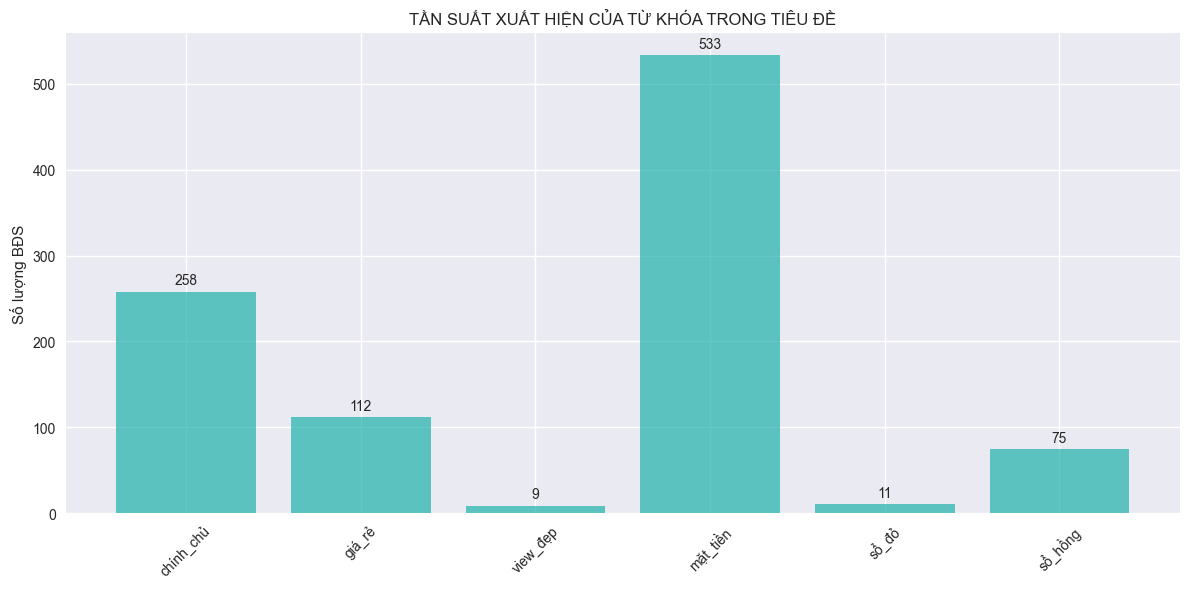

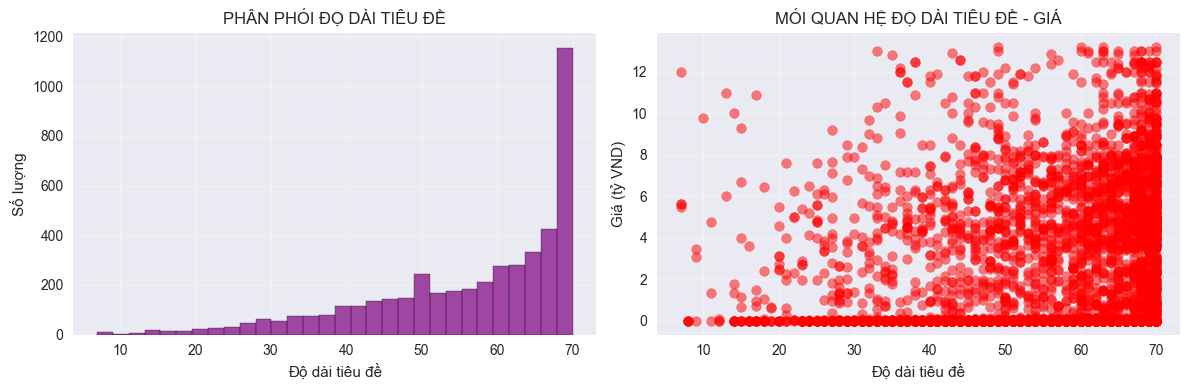

In [19]:
## PHÂN TÍCH CÁC BIẾN PHỤ TRỢ

# %%
if len(df) > 0:
    # 6.1 Phân tích từ khóa trong tiêu đề
    keyword_cols = [col for col in df.columns if 'Keyword' in col]

    if keyword_cols:
        print("🔍 PHÂN TÍCH TỪ KHÓA TRONG TIÊU ĐỀ")
        
        plt.figure(figsize=(12, 6))
        keyword_stats = {}
        
        for keyword_col in keyword_cols:
            count = df[keyword_col].sum()
            percentage = (count / len(df)) * 100
            keyword_name = keyword_col.replace('Keyword_', '')
            keyword_stats[keyword_name] = count
            print(f"{keyword_name:<15}: {count:>4} BĐS ({percentage:.1f}%)")
        
        # Biểu đồ từ khóa
        plt.bar(keyword_stats.keys(), keyword_stats.values(), color='lightseagreen', alpha=0.7)
        plt.title('TẦN SUẤT XUẤT HIỆN CỦA TỪ KHÓA TRONG TIÊU ĐỀ')
        plt.xticks(rotation=45)
        plt.ylabel('Số lượng BĐS')
        
        # Thêm số liệu trên cột
        for i, v in enumerate(keyword_stats.values()):
            plt.text(i, v + 5, f'{v}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

    # 6.2 Phân tích độ dài tiêu đề
    if 'Title_Length' in df.columns:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(df['Title_Length'], bins=30, alpha=0.7, edgecolor='black', color='purple')
        plt.xlabel('Độ dài tiêu đề')
        plt.ylabel('Số lượng')
        plt.title('PHÂN PHỐI ĐỘ DÀI TIÊU ĐỀ')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.scatter(df['Title_Length'], df['Price_clean']/1e9, alpha=0.5, color='red')
        plt.xlabel('Độ dài tiêu đề')
        plt.ylabel('Giá (tỷ VND)')
        plt.title('MỐI QUAN HỆ ĐỘ DÀI TIÊU ĐỀ - GIÁ')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

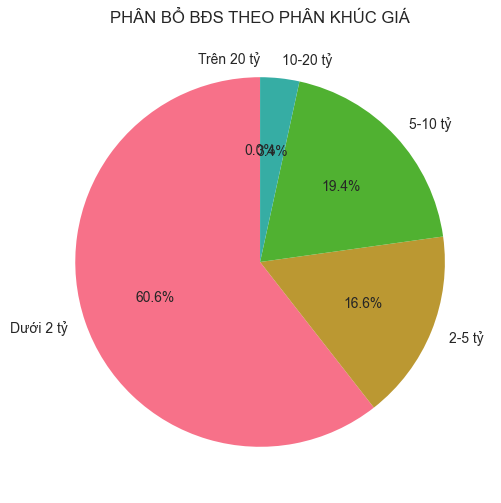

📊 PHÂN KHÚC GIÁ THỊ TRƯỜNG:
Dưới 2 tỷ   : 2816 BĐS (60.6%)
2-5 tỷ      :  774 BĐS (16.6%)
5-10 tỷ     :  901 BĐS (19.4%)
10-20 tỷ    :  159 BĐS (3.4%)
Trên 20 tỷ  :    0 BĐS (0.0%)

📊 PHÂN KHÚC DIỆN TÍCH:
Dưới 50m²   :  189 BĐS (4.1%)
50-80m²     :  229 BĐS (4.9%)
80-120m²    : 4134 BĐS (88.9%)
120-200m²   :   98 BĐS (2.1%)
Trên 200m²  :    0 BĐS (0.0%)


In [20]:
##  PHÂN TÍCH NGOẠI LỆ VÀ CỤM GIÁ TRỊ

# %%
if len(df) > 0:
    # 7.1 Phân tích các segment giá
    def create_price_segments(price_series):
        segments = {
            'Dưới 2 tỷ': (0, 2e9),
            '2-5 tỷ': (2e9, 5e9),
            '5-10 tỷ': (5e9, 10e9),
            '10-20 tỷ': (10e9, 20e9),
            'Trên 20 tỷ': (20e9, float('inf'))
        }
        
        segment_counts = {}
        for segment, (low, high) in segments.items():
            count = ((price_series >= low) & (price_series < high)).sum()
            segment_counts[segment] = count
        
        return segment_counts

    price_segments = create_price_segments(df['Price_clean'])

    plt.figure(figsize=(10, 6))
    plt.pie(price_segments.values(), labels=price_segments.keys(), autopct='%1.1f%%', startangle=90)
    plt.title('PHÂN BỔ BĐS THEO PHÂN KHÚC GIÁ')
    plt.show()

    print("📊 PHÂN KHÚC GIÁ THỊ TRƯỜNG:")
    for segment, count in price_segments.items():
        percentage = (count / len(df)) * 100
        print(f"{segment:<12}: {count:>4} BĐS ({percentage:.1f}%)")

    # 7.2 Phân tích các segment diện tích
    def create_area_segments(area_series):
        segments = {
            'Dưới 50m²': (0, 50),
            '50-80m²': (50, 80),
            '80-120m²': (80, 120),
            '120-200m²': (120, 200),
            'Trên 200m²': (200, float('inf'))
        }
        
        segment_counts = {}
        for segment, (low, high) in segments.items():
            count = ((area_series >= low) & (area_series < high)).sum()
            segment_counts[segment] = count
        
        return segment_counts

    area_segments = create_area_segments(df['Area_clean'])

    print("\n📊 PHÂN KHÚC DIỆN TÍCH:")
    for segment, count in area_segments.items():
        percentage = (count / len(df)) * 100
        print(f"{segment:<12}: {count:>4} BĐS ({percentage:.1f}%)")

In [21]:
## KẾT LUẬN EDA TỔNG QUAN

# %%
if len(df) > 0:
    print(" KẾT LUẬN EDA TỔNG QUAN")
    print("=" * 50)

    # Thống kê tổng quan
    print(f"• Tổng số BĐS phân tích: {len(df):,}")
    print(f"• Giá trung bình: {df['Price_clean'].mean()/1e9:.1f} tỷ VND")
    print(f"• Diện tích trung bình: {df['Area_clean'].mean():.0f} m²")
    print(f"• Giá/m² trung bình: {df['Price_per_m2'].mean()/1e6:.1f} triệu VND/m²")

    # Phân tích độ biến động
    price_cv = (df['Price_clean'].std() / df['Price_clean'].mean()) * 100
    area_cv = (df['Area_clean'].std() / df['Area_clean'].mean()) * 100

    print(f"• Độ biến động giá: {price_cv:.1f}%")
    print(f"• Độ biến động diện tích: {area_cv:.1f}%")

    # Phân tích tương quan
    if 'Area_clean' in df.columns and 'Price_clean' in df.columns:
        correlation = df['Area_clean'].corr(df['Price_clean'])
        print(f"• Tương quan Diện tích-Giá: {correlation:.3f}")

    # Lưu kết quả EDA
    eda_summary = {
        'total_properties': len(df),
        'avg_price': df['Price_clean'].mean(),
        'avg_area': df['Area_clean'].mean(),
        'avg_price_per_m2': df['Price_per_m2'].mean(),
        'price_std': df['Price_clean'].std(),
        'area_std': df['Area_clean'].std()
    }

    print(" HOÀN TẤT PHÂN TÍCH EDA!")
else:
    print(" KHÔNG THỂ THỰC HIỆN EDA DO THIẾU DỮ LIỆU")


 KẾT LUẬN EDA TỔNG QUAN
• Tổng số BĐS phân tích: 4,650
• Giá trung bình: 2.5 tỷ VND
• Diện tích trung bình: 104 m²
• Giá/m² trung bình: 25.1 triệu VND/m²
• Độ biến động giá: 132.5%
• Độ biến động diện tích: 17.6%
• Tương quan Diện tích-Giá: -0.002
 HOÀN TẤT PHÂN TÍCH EDA!
